# Text Classification: Sentiment Analysis

In [18]:
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
emotions = load_dataset("emotion")

Generating test split: 100%|██████████| 2000/2000 [00:00<00:00, 1019891.55 examples/s]


In [5]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [6]:
train_ds = emotions["train"]
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [10]:
train_ds[:5]

{'text': ['i didnt feel humiliated',
  'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
  'im grabbing a minute to post i feel greedy wrong',
  'i am ever feeling nostalgic about the fireplace i will know that it is still on the property',
  'i am feeling grouchy'],
 'label': [0, 0, 3, 2, 3]}

In [8]:
train_ds.column_names

['text', 'label']

In [9]:
print(train_ds.features)

{'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}


In [11]:
print(train_ds["text"][:5])

['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'im grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'i am feeling grouchy']


## From Datasets to DataFrames

In [13]:
emotions.set_format(type = "pandas")
df = emotions["train"][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [15]:
emotions["train"].features["label"]

ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)

In [16]:
def label_int2str(row):
    return emotions["train"].features["label"].int2str(row)

df["label_name"] = df["label"].apply(label_int2str)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


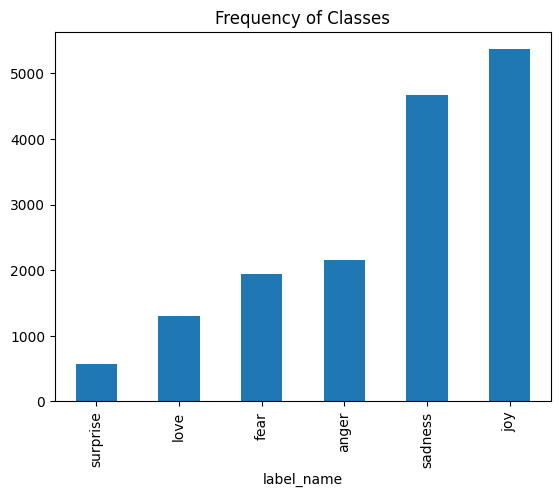

In [20]:
df["label_name"].value_counts(ascending = True).plot.bar()
plt.title("Frequency of Classes")
plt.show()

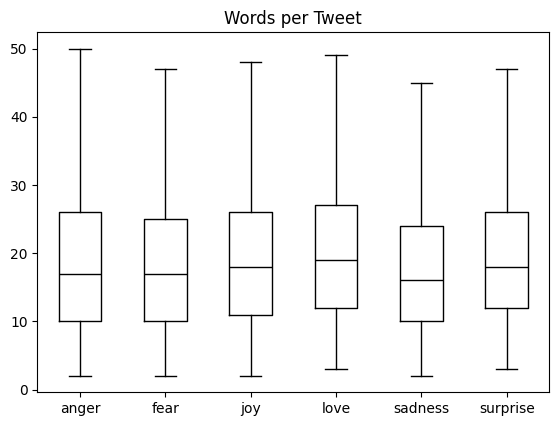

In [21]:
df["Words per Tweet"] = df["text"].str.split().apply(len)
df.boxplot("Words per Tweet", by = "label_name", grid = False,
           showfliers = False, color = "black")
plt.suptitle("")
plt.xlabel("")
plt.show()

In [23]:
emotions.reset_format()

## From Text To Tokens: Subword Tokenization